## Requirements
python==3.7.10  
tensorflow==2.1.0  
numpy==1.20.3  
seaborn==0.11.1  
matplotlib==3.4.2  
tenacity==7.0.0  
waylay-beta==0.2.0
opencv-python==4.5.2.54



In [1]:
# Imports
import tensorflow as tf
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

import cv2


In [2]:
MODEL_NAME='tensorflow-mnist'
IMAGE_SIZE = 28

## TensorFlow example

In this notebook we show how you can create and upload an image classifier using a TensorFlow model to Waylay. We will expect you to save your model using the [SavedModel format](https://www.tensorflow.org/guide/saved_model).

First let's import a dataset, the MNIST dataset. This is a classification dataset consisting of images, we will try to predict numbers 0 to 9 given in an image

In [3]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

x_train = x_train[:10000]
y_train = y_train[:10000]

print(f"Shape of training set: {x_train.shape}")
print(f"Shape of test set: {x_test.shape}")

Number of original training examples: 60000
Number of original test examples: 10000
Shape of training set: (10000, 28, 28)
Shape of test set: (10000, 28, 28)


Label of first example: 5


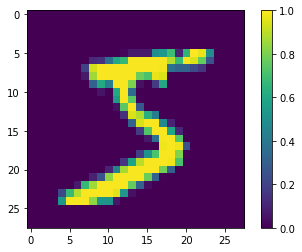

In [4]:
# Show the first example
print(f"Label of first example: {y_train[0]}")

plt.imshow(x_train[0, :, :])
plt.colorbar()


Now we can create a model, a simple one:

(10000, 28, 28, 1)


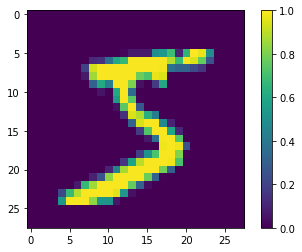

In [5]:
# Resize the images
x_train = np.array([cv2.resize(img, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR) for img in x_train])
x_test = np.array([cv2.resize(img, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR) for img in x_test])

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)

plt.imshow(x_train[0, :, :])
plt.colorbar()

In [6]:
lr = 0.001
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(10)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [7]:
model.fit(
    x_train,
    y_train,
    epochs=5,
)
print("Model has been trained")

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 4s 373us/sample - loss: 0.6604 - sparse_categorical_accuracy: 0.7939
Epoch 2/5
10000/10000 [==============================] - 4s 380us/sample - loss: 0.2711 - sparse_categorical_accuracy: 0.9287
Epoch 3/5
10000/10000 [==============================] - 4s 355us/sample - loss: 0.1903 - sparse_categorical_accuracy: 0.9499
Epoch 4/5
10000/10000 [==============================] - 3s 343us/sample - loss: 0.1448 - sparse_categorical_accuracy: 0.9657
Epoch 5/5
10000/10000 [==============================] - 4s 388us/sample - loss: 0.1166 - sparse_categorical_accuracy: 0.9702
Model has been trained


Let's test the model on our test set

In [8]:
print("Now testing model")
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, test accuracy: {test_acc}")

Now testing model
10000/10000 [==============================] - 1s 107us/sample - loss: 0.3750 - sparse_categorical_accuracy: 0.9387
Test loss: 0.3750359108631499, test accuracy: 0.9387000203132629


## Save the model and upload 

We will save the model in SavedModel format and then upload it to Waylay. 

In [9]:
from waylay import WaylayClient, RestResponseError

waylay = WaylayClient.from_profile()

In [10]:
# clean up existing model
import time
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
    time.sleep(5)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-io.waylay.io/models/tensorflow-mnist')"

In [11]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow image classifier mnist',
    timeout=500
)

result

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/tmpqek7faus/assets


{'message': 'Model successfully uploaded'}

After upload, it can take a few seconds before the model is available for execution.
You can expect to receive an error 
> 409 Model not ready yet

when executing the model too early.

In [12]:
result = waylay.byoml.model.get(MODEL_NAME)
result

{'createdBy': 'users/bd87db46-e8fc-4186-bdf4-a8f9478ed0d3',
 'createdOn': '2021-06-08T11:52:14.364637+00:00',
 'description': 'tensorflow image classifier mnist',
 'framework': 'tensorflow',
 'name': 'tensorflow-mnist',
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/bd87db46-e8fc-4186-bdf4-a8f9478ed0d3',
 'updatedOn': '2021-06-08T11:52:14.364671+00:00'}

We will now run the model on the first 10 samples of our test set

In [13]:
predictions = waylay.byoml.model.predict(MODEL_NAME, x_test[:10])

[7 2 1 0 4 1 4 9 4 9]


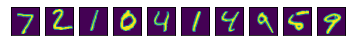

In [14]:
fig = plt.figure()

for sample in range(10):
    fig.add_subplot(1, 10, sample + 1)
    
    # Remove axes 
    ax = fig.gca()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.imshow(x_test[sample, :, :])

predicted_classes = np.argmax(predictions, axis = 1)
print(predicted_classes)

Compare with the locally trained model

In [15]:
local_predictions = model.predict(x_test[:10])
np.argmax(local_predictions, axis = 1)

array([7, 2, 1, 0, 4, 1, 4, 9, 4, 9])

In [16]:
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted'}